In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    InputLayer,
    MaxPool2D,
)

In [ ]:
TRAINING_DATA = "/content/drive/My Drive/gfriend/train"

batch_size = 32
seed = 1337

img_height = 256
img_width = 256

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAINING_DATA,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=seed,
    validation_split=0.3,
    subset="training",
)

Found 1521 files belonging to 6 classes.
Using 1065 files for training.


In [ ]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAINING_DATA,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=seed,
    validation_split=0.3,
    subset="validation",
)

Found 1521 files belonging to 6 classes.
Using 456 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['eunha', 'sinb', 'sowon', 'umji', 'yerin', 'yuju']


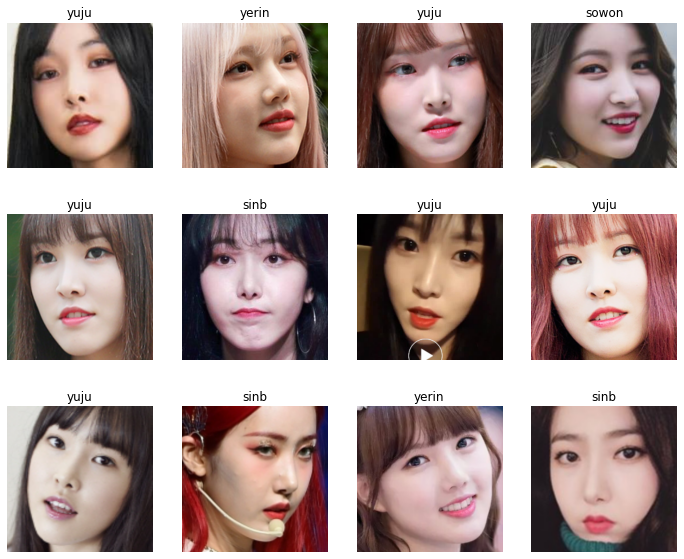

In [ ]:
plt.figure(figsize=(12, 10))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
    ],
    name="augmentation"
)

model = tf.keras.Sequential(
    [
        InputLayer(input_shape=(img_height, img_width, 3)),
        data_augmentation,
        tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255, name="normalization"),
        Conv2D(16, kernel_size=(3, 3), padding="same", activation="relu", name="conv1"),
        MaxPool2D(pool_size=(2, 2), name="pool1"),
        Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu", name="conv2"),
        MaxPool2D(pool_size=(2, 2), name="pool2"),
        Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu", name="conv3"),
        MaxPool2D(pool_size=(2, 2), name="pool3"),
        Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu", name="conv4"),
        MaxPool2D(pool_size=(2, 2), name="pool4"),
        Conv2D(256, kernel_size=(3, 3), padding="same", activation="relu", name="conv5"),
        MaxPool2D(pool_size=(2, 2), name="pool5"),
        Conv2D(512, kernel_size=(3, 3), padding="same", activation="relu", name="conv6"),
        MaxPool2D(pool_size=(2, 2), name="pool6"),
        Flatten(name="flatten"),
        Dropout(0.3, name="dropout1"),
        Dense(128, activation="relu", name="fc1"),
        Dense(len(class_names), activation="softmax", name="fc2"),
    ],
    name="gfriend"
)

model.summary()

Model: "gfriend"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
augmentation (Sequential)    (None, 256, 256, 3)       0         
_________________________________________________________________
normalization (Rescaling)    (None, 256, 256, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 256, 16)      448       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 128, 128, 16)      0         
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 128, 32)      4640      
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 64, 64, 64)        1849

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

In [ ]:
epochs = 100

es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, verbose=1)

checkpoint = "checkpoint.ckpt"
mc = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
)

history = model.fit(
    train_ds,
    validation_data=valid_ds,
    batch_size=batch_size,
    epochs=epochs,
    verbose=2,
    callbacks=[es, mc],
)

Epoch 1/100

Epoch 00001: val_loss improved from inf to 1.73023, saving model to checkpoint.ckpt
34/34 - 724s - loss: 1.7366 - accuracy: 0.2263 - val_loss: 1.7302 - val_accuracy: 0.2215
Epoch 2/100

Epoch 00002: val_loss improved from 1.73023 to 1.70056, saving model to checkpoint.ckpt
34/34 - 2s - loss: 1.7122 - accuracy: 0.2310 - val_loss: 1.7006 - val_accuracy: 0.3026
Epoch 3/100

Epoch 00003: val_loss improved from 1.70056 to 1.59141, saving model to checkpoint.ckpt
34/34 - 2s - loss: 1.6868 - accuracy: 0.3052 - val_loss: 1.5914 - val_accuracy: 0.3706
Epoch 4/100

Epoch 00004: val_loss improved from 1.59141 to 1.50676, saving model to checkpoint.ckpt
34/34 - 2s - loss: 1.5357 - accuracy: 0.3822 - val_loss: 1.5068 - val_accuracy: 0.3421
Epoch 5/100

Epoch 00005: val_loss improved from 1.50676 to 1.45855, saving model to checkpoint.ckpt
34/34 - 2s - loss: 1.4491 - accuracy: 0.4094 - val_loss: 1.4586 - val_accuracy: 0.4057
Epoch 6/100

Epoch 00006: val_loss improved from 1.45855 to 1.

In [ ]:
model.load_weights(checkpoint)

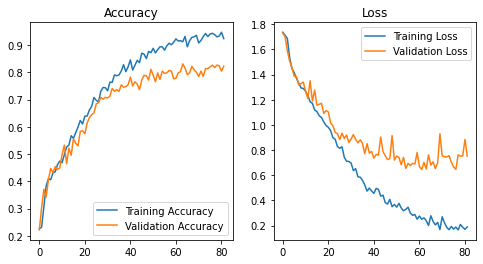

In [ ]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Loss")

plt.show()

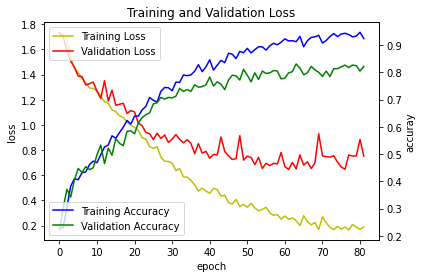

In [ ]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history["loss"], "y", label="Training Loss")
loss_ax.plot(history.history["val_loss"], "r", label="Validation Loss")

acc_ax.plot(history.history["accuracy"], "b", label="Training Accuracy")
acc_ax.plot(history.history["val_accuracy"], "g", label="Validation Accuracy")

loss_ax.set_xlabel("epoch")
loss_ax.set_ylabel("loss")
acc_ax.set_ylabel("accuray")

loss_ax.legend(loc="upper left")
acc_ax.legend(loc="lower left")

plt.title("Training and Validation Loss")

plt.show()

In [ ]:
# model = tf.keras.models.load_model("/content/drive/MyDrive/gfriend/model-0.75.h5")

# model.summary()

In [ ]:
TEST_DATA = "/content/drive/My Drive/gfriend/test"

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DATA,
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    batch_size=36,
    image_size=(img_height, img_width),
    shuffle=False,
)

Found 36 files belonging to 6 classes.


In [ ]:
test_loss, test_accuracy = model.evaluate(test_ds, verbose=2)

1/1 - 0s - loss: 0.9036 - accuracy: 0.7089


In [ ]:
model.save("model.h5")

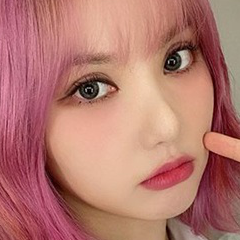

In [ ]:
from IPython.display import Image

Image("/content/drive/My Drive/gfriend/test/eunha/26.2020021016265282518_1.jpg_123_138.png")

In [ ]:
img_path = "/content/drive/My Drive/gfriend/test/eunha/6672640.438_521.png"
img = tf.keras.preprocessing.image.load_img(
    img_path, target_size=(img_height, img_width)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    f"This image most likely belongs to {class_names[np.argmax(score)]} with a {100 * np.max(score):.2f} percent confidence."
)
print(tf.nn.softmax(predictions[0]).numpy())

This image most likely belongs to eunha with a 34.26 percent confidence.
[0.3426067  0.13069628 0.13085309 0.13465391 0.13055626 0.13063377]


In [ ]:
from pathlib import Path

for img_path in Path("/content/drive/MyDrive/gfriend/test/eunha").iterdir():
    img = tf.keras.preprocessing.image.load_img(
        img_path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        f"This image most likely belongs to {class_names[np.argmax(score)]} with a {100 * np.max(score):.2f} percent confidence. {tf.nn.softmax(predictions[0]).numpy()}"
    )

This image most likely belongs to eunha with a 24.98 percent confidence. [0.24979691 0.14124984 0.13779485 0.17269392 0.1606892  0.13777521]
This image most likely belongs to eunha with a 35.17 percent confidence. [0.3516575  0.12961946 0.12961827 0.12962012 0.12986639 0.12961827]
This image most likely belongs to yerin with a 29.76 percent confidence. [0.16487166 0.13439126 0.1343692  0.13436921 0.29762948 0.13436916]
This image most likely belongs to eunha with a 35.15 percent confidence. [0.35154626 0.12963316 0.12963003 0.12963024 0.12975639 0.12980388]
This image most likely belongs to umji with a 24.58 percent confidence. [0.20249219 0.13757358 0.1384348  0.24584162 0.13852769 0.13713014]
This image most likely belongs to eunha with a 33.06 percent confidence. [0.3306099  0.13174206 0.13173467 0.13175029 0.13862497 0.13553807]
This image most likely belongs to eunha with a 34.24 percent confidence. [0.34235835 0.13059336 0.1305749  0.13101609 0.13488494 0.1305723 ]
This image mos

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255)
generator = datagen.flow_from_directory(
    TEST_DATA, target_size=(img_height, img_width), class_mode="sparse", batch_size=32
)


Found 79 images belonging to 6 classes.


In [ ]:
test_ds

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [ ]:
predictions = model.predict(test_ds)
len(predictions)

36

In [ ]:
for images, labels in test_ds.take(1):
    # print(images[0] / 255)
    t = 0
    f = 0
    for i in range(10):
        label = class_names[labels[i]]
        pred = class_names[np.argmax(tf.nn.softmax(predictions[i]))]
        print(class_names[labels[i]], end=" ")
        print(class_names[np.argmax(tf.nn.softmax(predictions[i]))], end=" ")
        print(tf.nn.softmax(predictions[i]))
        if label == pred:
            t += 1
        else:
            f += 1
    print(t, f)

eunha eunha tf.Tensor([0.24575423 0.14180149 0.1380044  0.17414005 0.16231665 0.13798319], shape=(6,), dtype=float32)
eunha eunha tf.Tensor([0.35156643 0.12962921 0.12962782 0.12963022 0.12991846 0.12962782], shape=(6,), dtype=float32)
eunha yerin tf.Tensor([0.21390052 0.1369634  0.13694568 0.13694572 0.23829907 0.13694564], shape=(6,), dtype=float32)
eunha eunha tf.Tensor([0.35134    0.12965612 0.12965171 0.12965195 0.12985578 0.12984446], shape=(6,), dtype=float32)
eunha umji tf.Tensor([0.21850878 0.13827941 0.13880107 0.22695163 0.13992506 0.13753399], shape=(6,), dtype=float32)
eunha eunha tf.Tensor([0.3243615  0.1323522  0.13232996 0.13234806 0.14029965 0.13830861], shape=(6,), dtype=float32)
eunha eunha tf.Tensor([0.342356   0.13059476 0.13057466 0.13097262 0.13492958 0.13057233], shape=(6,), dtype=float32)
eunha eunha tf.Tensor([0.34518376 0.13028781 0.13028613 0.13028699 0.13366921 0.1302861 ], shape=(6,), dtype=float32)
eunha eunha tf.Tensor([0.33556682 0.13123485 0.1312318  0

In [ ]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1.0 / 255)

normalized_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.043979783 1.0


In [ ]:
def plot_image(i, predictions, labels, img):
    predictions, labels, img = predictions[i], labels[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img / 255.0, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions)
    if predicted_label == labels:
        color = "#f0eee9"
    else:
        color = "#00abc0"

    plt.xlabel(
        "{} {:2.0f}% ({})".format(
            class_names[predicted_label],
            100 * np.max(tf.nn.softmax(predictions)),
            class_names[labels],
        ),
        color=color,
    )


def plot_value_array(i, predictions, labels):
    predictions, labels = predictions[i], labels[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(len(class_names)), 100 * tf.nn.softmax(predictions), color="#777777")
    plt.ylim([0, 100])
    predicted_label = np.argmax(predictions)

    thisplot[predicted_label].set_color("#00abc0")
    thisplot[labels].set_color("#5f4b8b")

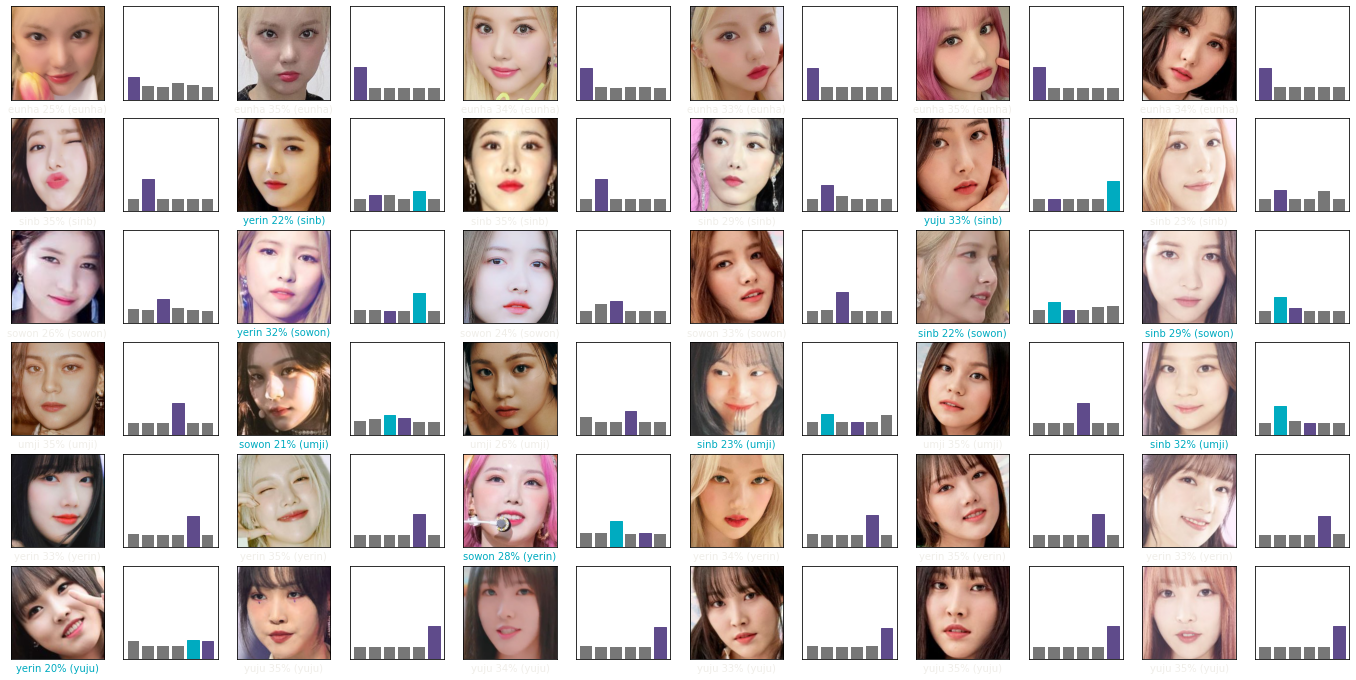

In [ ]:
num_rows = 6
num_cols = 6
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))

for images, labels in test_ds.take(1):
    # print(len(labels), labels)
    # print(len(images), images[0][0][0])
    for i in range(num_images):
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
        plot_image(i, predictions, labels, images)
        plt.subplot(num_rows, 2 * num_cols, 2 * i + 2)
        plot_value_array(i, predictions, labels)

plt.show()